# Credit Card Fraud Detection

The previous exercises made you take a closer look at all the different parts of a neural network: 
* the architecture of a sequential Dense Neural Network, 
* the compilation method
* the fitting.

Let's now work on a real-life dataset that has **a lot of data**!

**The dataset: `Credit Card Transactions`**

For this open challenge, you will `work with data extracted from credit card transactions`. 

As this is `sensitive data`, only 3 columns are known out of a total 31: the rest have been transformed to `anonymize` them (in fact, they are `PCA projections of initial data`).

The 3 known columns are:

* `TIME`: the time elapsed between the transaction and the first transaction in the dataset
* `AMOUNT`: the amount of the transaction
* `CLASS` (our target): 
    * `0 : valid transaction` 
    * `1 : fraudulent transaction`

❓ **Question** ❓ Start by downloading the dataset:
* on the Kaggle website [here](https://www.kaggle.com/mlg-ulb/creditcardfraud) 
* or from our [URL](https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/creditcard.csv) 

Load data to create `X` and `y`

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras import Sequential, layers, Input
from keras.layers import Dense, Dropout, Normalization
from keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall

In [51]:
data = pd.read_csv('creditcard.csv')
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## 1. Rebalancing classes

In [52]:
# Let's check class balance
y = data.Class
X = data.drop(columns='Class')
pd.Series(y).value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

☝️ in this `fraud detection` challenge, **the classes are extremely imbalanced**:
* 99.8 % of normal transactions
* 0.2 % of fraudulent transactions

**We won't be able to detect cases of fraud unless we apply some serious rebalancing strategies!**

❓ **Question** ❓
1. **First**, create three separate splits `Train/Val/Test` from your dataset. It is extremely important to keep validation and testing sets **unbalanced** so that when you evaluate your model, it is done in true conditions, without data leakage. Keep your test set for the very last cell of this notebook!

&nbsp;
2. **Second**, rebalance your training set (and only this one). You have many choices:

- Simply oversample the minority class randomly using plain Numpy functions (not the best option since you are duplicating rows and hence creating data leakage)
- Or use <a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/">**`Synthetic Minority Oversampling Technique - SMOTE`**</a> to generate new datapoints by weighting the existing ones
- In addition, you can also try a <a href="https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/">**`RandomUnderSampler`**</a> to downsample the majority class a little bit

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)
pd.Series(y_val).value_counts(normalize=True)

Class
0    0.998278
1    0.001722
Name: proportion, dtype: float64

In [54]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

X_train, y_train = RandomUnderSampler(sampling_strategy=0.1).fit_resample(X_train, y_train)
X_train, y_train = SMOTE(sampling_strategy=0.25).fit_resample(X_train, y_train)

pd.Series(y_train).value_counts(normalize=True)

Class
0    0.800133
1    0.199867
Name: proportion, dtype: float64

## 2. Neural Network iterations

Now that you have rebalanced your classes, try to fit a neural network to optimize your test score. Feel free to use the following hints:

- Normalize your inputs!
    - Use preferably a [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) layer inside the model to "pipeline" your preprocessing within your model. 
    - Or use sklearn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) outside of your model, applied your `X_train` and `X_val` and `X_test`.
- Make your model overfit, then regularize  it using:
    - Early Stopping criteria 
    - [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers
    - or [`regularizers`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) layers
- 🚨 Think carefully about the metrics you want to track and the loss function you want to use!


In [57]:
def initialize_model():
    model = Sequential()
    scaler = Normalization()
    scaler.adapt(X_train.to_numpy())
    model.add(scaler)

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.add(layers.Dense(1, 'sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        metrics=['accuracy', 'recall', Precision()],
        optimizer='adam',
        )
    return model

In [ ]:
model = initialize_model()
history = model.fit(X_train, y_train, epochs=1000,validation_data=(X_val, y_val), shuffle=True, callbacks=EarlyStopping(patience=50, restore_best_weights=True))

Epoch 1/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7888 - loss: 0.5642 - precision_2: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9983 - val_loss: 0.3658 - val_precision_2: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7898 - loss: 0.4495 - precision_2: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9983 - val_loss: 0.3172 - val_precision_2: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7937 - loss: 0.4162 - precision_2: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9983 - val_loss: 0.2789 - val_precision_2: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7969 - loss: 0.3905 - precision_2: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9983 - val_loss: 0.2483 - val_precision_2: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7960 - lo

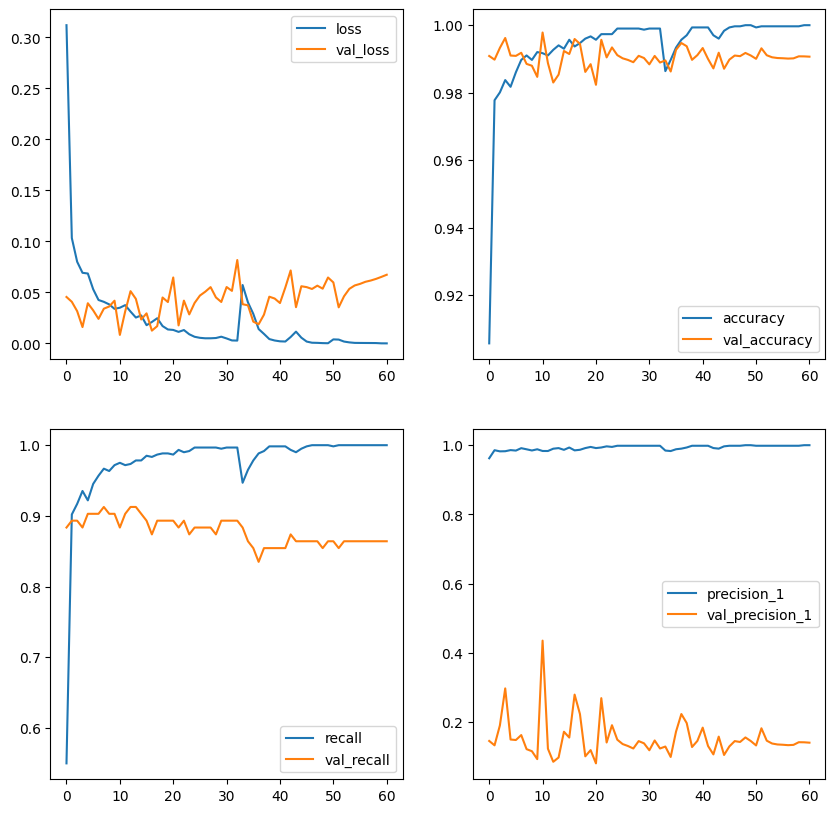

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.lineplot(history.history['loss'], ax=ax[0,0], label='loss')
sns.lineplot(history.history['val_loss'], ax=ax[0,0], label='val_loss')

sns.lineplot(history.history['accuracy'], ax=ax[0,1], label='accuracy')
sns.lineplot(history.history['val_accuracy'], ax=ax[0,1], label='val_accuracy')

sns.lineplot(history.history['recall'], ax=ax[1,0], label='recall')
sns.lineplot(history.history['val_recall'], ax=ax[1,0], label='val_recall')

sns.lineplot(history.history['precision_1'], ax=ax[1,1], label='precision_1')
sns.lineplot(history.history['val_precision_1'], ax=ax[1,1], label='val_precision_1');

### 🧪 Test your score

Store below your real test performance on a (`X_test`, `y_test`) representative sample of the original unbalanced dataset into `precision` and `recall` variables.

In [ ]:
loss, accuarcy, recall, precision = model.evaluate(X_test, y_test)
print(loss, accuarcy, recall, precision)

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9980 - loss: 0.0086 - precision_1: 0.4862 - recall: 0.8864
0.00981527753174305 0.9975305199623108 0.8513513803482056 0.4000000059604645


In [43]:
from nbresult import ChallengeResult

result = ChallengeResult('solution',
    precision=precision,
    recall=recall,
    fraud_number=len(y_test[y_test == 1]),
    non_fraud_number=len(y_test[y_test == 0]),
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/bat/.pyenv/versions/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/bat/code/syanrys/06-Deep-Learning/02-Optimizer-loss-and-fitting/data-credit-card-challenge/tests
plugins: dash-3.0.4, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_solution.py::TestSolution::test_is_score_good_enough PASSED         [ 50%]
test_solution.py::TestSolution::test_is_test_set_representative PASSED   [100%]

============================== 2 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/solution.pickle

git commit -m 'Completed solution step'

git push origin master



## 🏁 Optional: Read Google's solution for this challenge
Congratulations for finishing all challenges for this session!

To conclude, take some time to read Google's own solution direcly [on Colab here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb). 

You will discover interesting techniques and best practices